In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import operator

from nltk.corpus import stopwords
stop = stopwords.words('english')

import string
from string import digits
punctuation = string.punctuation

from pandasql import sqldf

import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns

/Users/sherryguo/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 1. Overview of database

In [2]:
#import data
df_list=pd.read_csv('listings.csv')
df_review=pd.read_csv('reviews.csv',parse_dates=['date'])
df_cal=pd.read_csv('calendar.csv',parse_dates=['date'])

/Users/sherryguo/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (61,62) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
df_review.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,109,449036,2011-08-15,927861,Edwin,The host canceled my reservation the day befor...
1,109,74506539,2016-05-15,22509885,Jenn,Me and two friends stayed for four and a half ...
2,344,79805581,2016-06-14,2089550,Drew & Katie,We really enjoyed our stay here in Burbank! Th...
3,344,120725697,2016-12-11,32602867,Christopher,I had a ton of fun learning to play Go with Fu...
4,344,123800867,2016-12-30,35822259,May,The host canceled this reservation the day bef...


## 1.1 Listing

There are 45053 unique listings in LA. 

In [3]:
unique_listing=df_list.id.nunique()
print(unique_listing)

45053


The recorded prices start from 2019-09-14 and end at 2020-09-12

In [14]:
df_cal['date'].max(),df_cal['date'].min()

('2020-09-12', '2019-09-14')

## 1.2 Host

There are 26286 unique hosts in LA in total.

In [5]:
print(df_list.host_id.nunique())

26286


On average, each host has 12 listings.  
The maximum and minimum number of listings per host is 29584 and 1.  
The number of listings per host varies a lot. 

In [6]:
df_2=df_list.groupby(by=['host_id'])['calculated_host_listings_count'].sum()
df_2a=df_2.agg([np.mean,np.median,np.std, np.min, np.max])
df_2a

mean         11.932397
median        1.000000
std         242.143721
amin          1.000000
amax      29584.000000
Name: calculated_host_listings_count, dtype: float64

## 1.3 Reviews

There are 1509564 reviews in total.

In [10]:
df_review.shape[0]

1509564

# 2. Analysis of Data Quality

## 2.1 Key Features

In [ ]:
# extract key columns we want to analysis
list_columns=['listing_id','price','room_type','neighbourhood','beds'
              'host_id','calculated_host_listings_count','host_is_superhost','host_verifications',
              'number_of_reviews','reviews_per_month','review_scores_location', 'review_scores_cleanliness','review_scores_rating',
              'zipcode','latitude','longitude']
df_list=df_list[list_columns]

## 2.2 Missing Data

In [4]:
#find all missing data
miss_listings = df_list.isnull()
miss_cal=df_cal.isnull()
miss_review=df_review.isnull()
print(miss_listings.shape[0],miss_cal.shape[0],miss_review.shape[0])

45053 16444345 1509564


In [5]:
miss_listings.sum()

id                                                 0
listing_url                                        0
scrape_id                                          0
last_scraped                                       0
name                                               6
                                                ... 
calculated_host_listings_count                     0
calculated_host_listings_count_entire_homes        0
calculated_host_listings_count_private_rooms       0
calculated_host_listings_count_shared_rooms        0
reviews_per_month                               8519
Length: 106, dtype: int64

In [6]:
#remove all columns with more than 50% missing values
miss_50=df_list.columns[miss_listings.sum()/len(df_list)>0.5]
df_list=df_list.drop(miss_50,axis=1)

#fill other missing values
df_list.fillna(0,inplace=True)

In [24]:
miss_50

Index(['thumbnail_url', 'medium_url', 'xl_picture_url', 'host_acceptance_rate',
       'neighbourhood_group_cleansed', 'square_feet', 'weekly_price',
       'monthly_price', 'license'],
      dtype='object')

## 2.2 Data Transforming

In [7]:
#price: in string format; transform into float values
def getmoney(price):
    str_pri=str(price)
    str_price=str_pri.replace(",","").strip('$')
    num_price=float(str_price)
    return num_price
df_list['price']=df_list['price'].apply(getmoney)
df_cal['price']=df_cal['price'].apply(getmoney)

In [41]:
#comments: only select comments in English and normalize text
for index, row in df_review.iterrows():
        l=row['comments']
        if type(l) is str:
            l=l.lower()
            list1 = "".join(c for c in l if (c not in string.punctuation and not c.isdigit()))        
            df_7a.loc[index,'comments']=list1
        else:
            df_7a.drop(index, axis=0, inplace=True)
    df_7s=df_7a['comments'].apply(lambda x: [item for item in x.split(' ') if (item not in stop)])

In [ ]:
# Boolean types are replaced with a 0 or 1
def repl_f_t(l):
    l = l.replace('f', 0);
    l = l.replace('t', 1);
    return l

In [8]:
#date
df_cal['date']=df_cal['date'].dt.date
df_review['date']=df_review['date'].dt.date

# 3. Exploratory Data Analysis

## 3.1 Spatial Data Analysis

#### 2) Zipcode

5 active zipcode with the highest average listing price and more than 30 listing are 90210, 90077, 93063, 90265, 90069. Their average listing price are 1963.557367, 1909.066130, 1567.562500, 1559.605010, 998.113153 respectively. The number of active listings are 278, 74, 2, 329, 423 and the number of hosts are 173, 48, 1, 221, 305. 

In [11]:
df_8a=df_cal.loc[(df_cal.date>='2020-01-01') & (df_cal.date<='2020-02-01') &\
                 (df_cal.available=='t'), :]
df_8a["price2"]=df_8a.price.apply(getmoney)
df_8b=df_8a.merge(df_list,how = "left", left_on = "listing_id", right_on="id").\
                  loc[:,["listing_id","price2","zipcode","host_id"]]
df_8c=df_8b.groupby(by=['zipcode']).filter(lambda x:x['listing_id'].count()>=30)
df_8d=sqldf('SELECT zipcode, AVG(price2) AS avg_price2, COUNT(DISTINCT listing_id) AS listing_id_count, \
             COUNT(DISTINCT host_id) AS host_id_count FROM df_8c GROUP BY zipcode ORDER BY avg_price2 DESC\
             LIMIT 5')
df_8d.head()

/Users/sherryguo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,zipcode,avg_price2,listing_id_count,host_id_count
0,90210,1963.557367,278,173
1,90077,1909.066130,74,48
2,93063,1567.562500,2,1
3,90265,1559.605010,329,221
4,90069,998.113153,423,305


Five zipcodes that have at least 30 listings and have the largest absolute difference between the average prices on weekends versus the average prices on weekdays are 91001, 91105, 93063, 90210, 90305

In [12]:
df_9a=df_cal.loc[(df_cal.date>=dt.date(2020,1,1)) & (df_cal.date<=dt.date(2020,4,1)) &\
                 (df_cal.available=='t'), :]
df_9a["dayofweek"] = df_9a.dt.dayofweek
df_9a["weekday"] = df_9a["dayofweek"].apply(lambda x:"Weekend"if x[0]== "S" else ("Weekday"))
df_9b=df_9a.merge(df_list,how = "left", left_on = "listing_id", right_on="id")\
                  .loc[:,["date","dayofweek","weekday","listing_id","price","zipcode","host_id"]]
df_9c=df_9b.groupby(by=['zipcode']).filter(lambda x:x['listing_id'].count()>=30)
df_9d=sqldf("SELECT * FROM df_9c WHERE weekday='Weekday' GROUP BY zipcode")
df_9d=df_9d.groupby(by=["zipcode"])['price'].agg({"price":np.mean}).sort_values(by=["price"],ascending=False)
df_9e=sqldf("SELECT * FROM df_9c WHERE weekday='Weekend' GROUP BY zipcode")
df_9e=df_9e.groupby(by=["zipcode"])['price'].agg({"price":np.mean}).sort_values(by=["price"],ascending=False)
df_9f=df_9d.merge(df_9e,how = "outer", left_on = "zipcode", right_on="zipcode")
df_9f["max_abs_dif"]=df_9f["price_x"]-df_9f["price_y"]
df_9f.sort_values(by=["max_abs_dif"],ascending=False).head()

/Users/sherryguo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/sherryguo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/sherryguo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

,price2_x,price2_y,max_abs_dif
zipcode,,,
91001,487.0,187.0,300.0
91105,365.0,125.0,240.0
93063,3700.0,3509.0,191.0
90210,1735.0,1567.0,168.0
90305,209.0,75.0,134.0


## 3.2 Price and D&S

1) Price of listing

In [123]:
# Analysis of the average price of a listing in Los Angles
df_6=df_cal.groupby(by=['listing_id'])['price'].mean().agg([np.max,np.min,np.mean,np.std])
round(df_6,4)

amax    25000.0000
amin       10.0274
mean      218.0288
std       580.2143
Name: price, dtype: float64

In [124]:
df_6b=df_cal.groupby(by=['date'])['price'].mean()
df_6b=pd.DataFrame(data=df_6b, columns=['price']).reset_index()

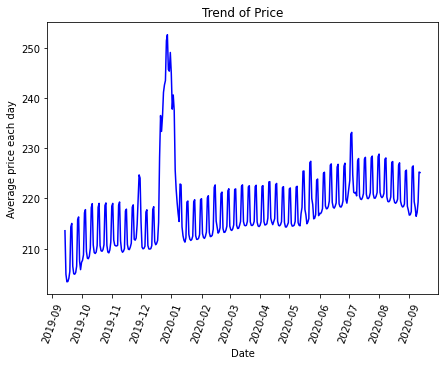

In [134]:
fig,ax=plt.subplots(figsize=(7,5))
ax.plot(df_6b.date,df_6b.price,color='b')
ax.set(title = "Trend of Price", xlabel="Date", ylabel="Average price each day")
ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=70)
plt.show()

In [48]:
# Analysis of the average price of a listing in Los Angles from 01/01/2020 to 03/01/2020 (inclusive)
df_6a=df_cal.loc[(df_cal.date>='2020-01-01') & (df_cal.date<='2020-03-01') &\
                 (df_cal.available=='t'), :]

df_6=df_6a.groupby(by=['listing_id'])['price'].mean().agg([np.max,np.min,np.mean,np.std])
round(df_6,4)

amax    25000.0000
amin       10.1475
mean      254.7782
std       684.7550
Name: price, dtype: float64

2) The number of reviews  
The number of reviews made has increased a lot.

In [9]:
df_6c=df_review.groupby(by=['date'])['id'].nunique()
df_6c=pd.DataFrame(data=df_6c, columns=['id']).reset_index()

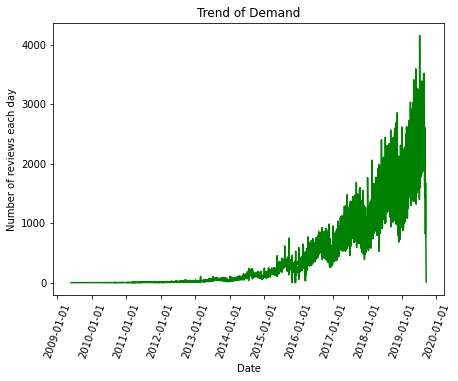

In [12]:
fig,ax=plt.subplots(figsize=(7,5))
ax.plot(df_6c.date,df_6c.id,color='g')
ax.set(title = "Trend of Demand", xlabel="Date", ylabel="Number of reviews each day")
ax.xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=70)
plt.show()

In [24]:
df_6c2=df_review.loc[df_review.date>=dt.date(2015,1,1), :].groupby(by=['date'])['id'].nunique()
df_6c2=pd.DataFrame(data=df_6c2, columns=['id']).reset_index()

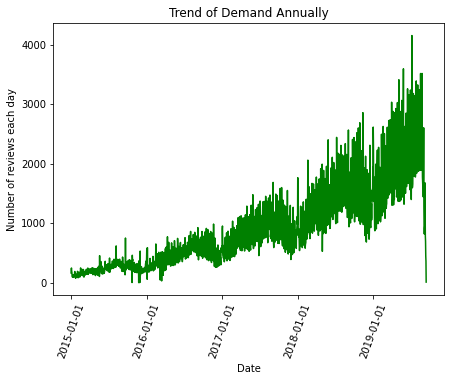

In [26]:
fig,ax=plt.subplots(figsize=(7,5))
ax.plot(df_6c2.date,df_6c2.id,color='g')
ax.set(title = "Trend of Demand Annually", xlabel="Date", ylabel="Number of reviews each day")
ax.xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=70)
plt.show()

3) Changes of number of listing  
Number of listing did not change.

In [138]:
df_6d=df_cal.groupby(by=['date'])['listing_id'].nunique().agg([np.max,np.min,np.mean,np.std])
df_6d

amax    45053.0
amin    45053.0
mean    45053.0
std         0.0
Name: listing_id, dtype: float64

In [18]:
df_6e=df_review.groupby(by=['date'])['listing_id'].nunique()
df_6e.agg([np.max,np.min,np.mean,np.std])

amax    4154.000000
amin       1.000000
mean     445.555062
std      610.237225
Name: listing_id, dtype: float64

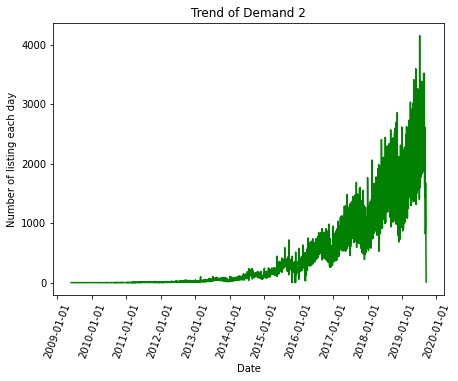

In [19]:
df_6e=pd.DataFrame(data=df_6e, columns=['listing_id']).reset_index()

fig,ax=plt.subplots(figsize=(7,5))
ax.plot(df_6e.date,df_6e.listing_id,color='g')
ax.set(title = "Trend of Demand 2", xlabel="Date", ylabel="Number of listing each day")
ax.xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=70)
plt.show()

From year 2009, Airbnb demand has continuously increasd. After year 2015, the demand has increased rapidly.   
We can see the peak and drop in each year: The demand is lowest in January and increases until October, when it begins to falls until the end of the year. This could possibly be due to the holiday season kicking in, with people celebrating Thanksgiving and Christmas at home with their family, leading to a slump in tourism and hence the demand for tourist lodging.

4) Daily capcaity

From 2020-01-01 to 2020-04-01:  
The average and standard deviation of the daily total capacity is 47091.648, 4921.138.  
The average and standard deviation of the daily price per bed is 124.060, 5.634.

In [13]:
ava_df_cal=df_cal.loc[(df_cal.date>=date(2020,1,1)) & (df_cal.date<date(2020,4,1))&\
            (df_cal.available=='t'), ["listing_id", "date", "price"]]
df_10a=df_list[['id','beds']].merge(ava_df_cal, how='inner', left_on='id', right_on='listing_id')

def getmoney(price):
    str_pri=str(price)
    str_price=str_pri.replace(",","").strip('$')
    num_price=float(str_price)
    return num_price

df_10a['price']=df_10a.price.apply(getmoney)

In [14]:
df_10b=df_10a.groupby(by='date').agg({'beds':np.sum, 'price': np.sum})
df_10b.reset_index(inplace=True)
df_10b.beds.mean(),df_10b.beds.std()

(47091.64835164835, 4921.138764720635)

In [15]:
df_10b['price_pre_bed']=df_10b.apply(lambda x: x['price']/x['beds'], axis=1)
df_10b.price_pre_bed.mean(), df_10b.price_pre_bed.std()

(124.06037237364912, 5.6335888355340975)

The daily occupancy trend from 2019-09-01 to 2020-09-01 (one year):  
Price reflects the demands of the market. By sharing the same x-axis, which is date, we can know that the occupancy keeps increasing from the beginning of Sep 2019 to the mid of Dec 2019, which could be a potential reason for Airbnb's host to increase the price. After Christmas and new year celebration, the demand of house decreases rapidly which simultaneously leads to a decrease in price.

In [16]:
#create a new database with target date and convert available data into numerical data
df_cal1=df_cal.loc[(df_cal.date>="2019-09-01") & (df_cal.date<="2020-09-01"), \
                   ["listing_id", "date", "available","price"]]

df_cal1['available_num']=df_cal1.available.apply(lambda x: 1 if x=='t' else 0)

In [17]:
#calculate occupancy
from pandasql import sqldf
df_q1a=sqldf("SELECT date, COUNT(listing_id) AS total_list, SUM(available_num) AS total_available FROM df_cal1 GROUP BY date")
df_q1a["Occupancy"]=df_q1a['total_available']/df_q1a["total_list"]
df_q1a.head()

,date,total_list,total_available,Occupancy
0,2019-09-14,45053,5516,0.122434
1,2019-09-15,45053,11558,0.256542
2,2019-09-16,45053,14748,0.327348
3,2019-09-17,45053,15816,0.351053
4,2019-09-18,45053,15935,0.353695


[Text(0, 0.5, 'Occupancy each day'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'Trend of Occupancy')]

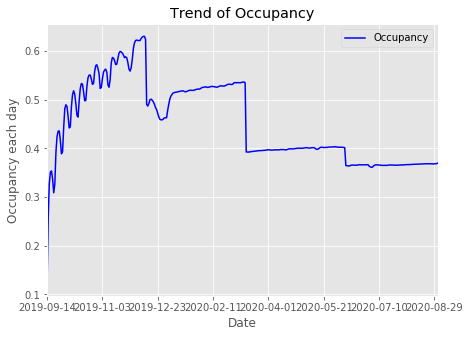

In [18]:
#plot result
import matplotlib.pyplot as plt
plt.style.use("ggplot")
fig, ax0=plt.subplots(nrows=1,ncols=1, figsize = (7,5))

df_q1a.plot(kind="line", x = "date", y = "Occupancy", color = 'b', label = "Occupancy",  ax = ax0 )
ax0.set(title = "Trend of Occupancy", xlabel="Date", ylabel="Occupancy each day")

4) Duration  
Definition: The duration is the number of nights booked per year of a listing.  
Most of the houses are under the normal range of 150-250. There are around 10 neighbourhoods that have a higher average durations with values greater than 250, which may indicates that the people in these neighbourhoods have a higher tendency to consider the house as a commercial house.

In [22]:
# Your code to answer Question 3

import numpy as np
df_q3a=df_cal.loc[(df_cal.date>="2019-09-01") & (df_cal.date<="2020-09-01")&\
            (df_cal.available=='t'), ["listing_id", "available","price"]]

df_q3a['price']=df_q3a.price.apply(getmoney)
df_q3b=sqldf("SELECT listing_id, COUNT(available) AS Duration, AVG(price) AS Avg_Price\
              FROM df_q3a GROUP BY listing_id")
df_q3b.head()

,listing_id,Duration,Avg_Price
0,109,154,122.000000
1,344,80,156.250000
2,2708,265,51.958491
3,2732,335,140.000000
4,5728,95,69.631579


In [23]:
df_q3c=df_q3b.merge(df_list[['id','neighbourhood']], how='left', left_on='listing_id', right_on='id')
df_q3d=sqldf("SELECT neighbourhood, AVG(Duration) AS avg_Duration, AVG(Avg_Price) AS Avg_Price_N\
              FROM df_q3c GROUP BY neighbourhood ORDER BY AVG(Duration) DESC")
df_q3e=sqldf("SELECT neighbourhood, COUNT(DISTINCT id) AS total_list, AVG(Avg_Price) AS Avg_Price_N\
              FROM df_q3c GROUP BY neighbourhood ORDER BY total_list DESC")

[Text(0, 0.5, 'Average Price'),
 Text(0.5, 0, 'Average Duration'),
 Text(0.5, 1.0, 'Listing Characters in Neighborhood')]

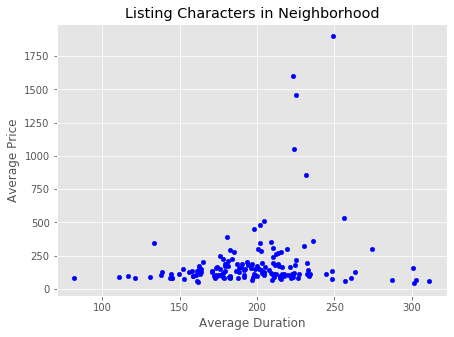

In [24]:
# plot the result
fig3, ax3_0=plt.subplots(nrows=1,ncols=1, figsize = (7,5))

df_q3d.plot(kind="scatter", x = "avg_Duration", y = "Avg_Price_N", color = 'b',  ax = ax3_0 )
ax3_0.set(title = "Listing Characters in Neighborhood", xlabel="Average Duration", ylabel="Average Price")

## 3.3 Host Data Analysis

1) What makes someone a superhost?

For super host, the average number of listings is 7.359 with a standard deviation of 20.867. For non-super host, the average number of listings is 6.795 with a standard deviation of 14.348.

In [15]:
df_3=df_list.groupby(by=['host_is_superhost'])['calculated_host_listings_count'].agg([np.mean,np.std])
df_3.reset_index(inplace=True)
df_3

,host_is_superhost,mean,std
0,f,6.795214,14.348464
1,t,7.359444,20.866644


2) What are the types of host verifications?

There are 22 unique types of host veriftication in LA rental market.  
The top 5 popular types are phone, email, reviews, government_id and offline_government_id

In [4]:
#unique types of verification and the total number of hosts verify that type
d={}
count=0
for i in range(len(df_list)):
    a=df_list["host_verifications"][i].strip("[").strip("]").replace(' ', '').split(",")
    for j in range(len(a)):
        if a[j] in d:
            d[a[j]]+=1
        else:
            d[a[j]]=1
    count+=len(a)

len(d)
d

{"'email'": 42359,
 "'phone'": 44881,
 "'facebook'": 8430,
 "'reviews'": 32907,
 "'kba'": 10762,
 "'jumio'": 20670,
 "'government_id'": 28789,
 "'offline_government_id'": 20906,
 "'selfie'": 13362,
 "'identity_manual'": 12284,
 "'work_email'": 6296,
 "'manual_online'": 307,
 "'manual_offline'": 611,
 "'google'": 3416,
 '': 7,
 "'sent_id'": 144,
 'None': 16,
 "'sesame'": 42,
 "'sesame_offline'": 42,
 "'photographer'": 3,
 "'zhima_selfie'": 181,
 "'weibo'": 78}

In [5]:
#popular verification types and the percent of hosts verify that type
for name in d.keys():
    precent=d[name]/count
    d[name]=round(precent,4)

sorted_d = sorted(d.items(), key=operator.itemgetter(1),reverse=True)
sorted_d

[("'phone'", 0.1821),
 ("'email'", 0.1718),
 ("'reviews'", 0.1335),
 ("'government_id'", 0.1168),
 ("'offline_government_id'", 0.0848),
 ("'jumio'", 0.0839),
 ("'selfie'", 0.0542),
 ("'identity_manual'", 0.0498),
 ("'kba'", 0.0437),
 ("'facebook'", 0.0342),
 ("'work_email'", 0.0255),
 ("'google'", 0.0139),
 ("'manual_offline'", 0.0025),
 ("'manual_online'", 0.0012),
 ("'zhima_selfie'", 0.0007),
 ("'sent_id'", 0.0006),
 ("'weibo'", 0.0003),
 ("'sesame'", 0.0002),
 ("'sesame_offline'", 0.0002),
 ('None', 0.0001),
 ('', 0.0),
 ("'photographer'", 0.0)]

## 3.4 User Reviews Analysis

#### Top words

In [52]:
df_review['date'].agg([np.max,np.min])

amax    2019-09-14
amin    2009-05-26
Name: date, dtype: object

In [61]:
#before convert date into date format
def gettopword(date, df_review):
    df_7a=df_review.loc[(df_review.date>=date[0]) & (df_review.date<=date[1]), :'comments']

    for index, row in df_7a.iterrows():
        l=row['comments']
        if type(l) is str:
            l=l.lower()
            list1 = "".join(c for c in l if (c not in string.punctuation and not c.isdigit()))        
            df_7a.loc[index,'comments']=list1
        else:
            df_7a.drop(index, axis=0, inplace=True)
    df_7s=df_7a['comments'].apply(lambda x: [item for item in x.split(' ') if (item not in stop)])

    wordcount={}
    for row in df_7s:
        for word in row:
            try:
                wordcount[word]+=1
            except:
                wordcount[word]=1

    wordcount_s=dict(sorted(wordcount.items(), key=operator.itemgetter(1), reverse=True)[1:11])
    return wordcount_s

In [ ]:
#top words from 2016-09-14 to 2019-09-14
wordcount=gettopword(df_review)
wordcount

In [8]:
wordcount1=gettopword(['2016-01-01','2016-01-31'], df_review)
wordcount1

{'great': 5374,
 'stay': 4661,
 'place': 4284,
 'clean': 2719,
 'location': 2694,
 'house': 2642,
 'us': 2631,
 'nice': 2404,
 'would': 2382,
 'host': 2325}

In [9]:
wordcount2=gettopword(['2017-03-01','2017-03-31'], df_review)
wordcount2

{'great': 12169,
 'place': 11528,
 'stay': 9453,
 'location': 5860,
 'clean': 5444,
 'nice': 4540,
 'would': 4514,
 'host': 4422,
 'house': 3769,
 'comfortable': 3756}

In [10]:
wordcount3=gettopword(['2018-04-01','2018-04-31'], df_review)
wordcount3

{'great': 18787,
 'place': 18654,
 'stay': 14741,
 'location': 9983,
 'clean': 9031,
 'would': 7263,
 'nice': 6797,
 'host': 6789,
 'house': 5516,
 'la': 5491}

#### Sentiment

We analyzed scores and review sentiment in order to find the 'best' host with high score and positive feedback from reviews.

# 4. Conclusions